In [488]:
import numpy as np
import pandas as pd
import mne
import os
import glob
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from scipy.stats import ttest_1samp
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier , RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

import math 


In [280]:
len(np.sort(glob.glob(sub3_s)))

5

In [332]:
def seizure_data_loader(data_folder_path, onset):
    """takes a data_folder_path (string) and onset (array-like) as inputs and returns an array of EEG signals that 
    contains 9 minutes prior to the seizure"""
    
    files   = np.sort(glob.glob(data_folder_path))
    start_time = [i-600 for i in onset]
    end_time = [j+544 for j in start_time]
    seizure_data = []

    
    #we iterate thorough each file that has seizure event in it. in the loop we crop, filter, and epoch the data based on the parameters that we defined in the previous block
    print(range(len(files)))
    for i in range(len(files)):
    #read raw EDF file
        raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)
        print(i)
        print(f'duration:{raw.times[-1]}')
        print(f'start: {start_time[i]}')
        print(f'end: {end_time[i]}')
    # crop the data to the selected time window
        raw.crop(tmin=start_time[i], tmax=end_time[i])
    # Apply the filter
        raw.filter(l_freq=32,h_freq=120,method='fir',fir_window='hamming',verbose=False)
    
    # Convert the epoched data to a NumPy array and append it to the list
        seizure_data.append(raw.get_data())            
    return np.asarray(seizure_data)



def nonseizure_data_loader(data_folder_path, number_of_samples):
    """take data_folder_path which should contain only one non_seizure files. number_of_samples is an integer that should
    match the number of samples in the seizure array"""
    file   = glob.glob(data_folder_path)
    raw = mne.io.read_raw_edf(file[0],preload=False,verbose=False)
    duration_sec = int(raw.times[-1])
    non_seizure_data = []
    onset  = np.sort(random.sample(range(600,duration_sec-544), number_of_samples))
    start_time = [i-600 for i in onset]
    end_time = [j+544 for j in start_time]
    
    for i in range(onset.shape[0]):
        raw = mne.io.read_raw_edf(file[0],preload=True,verbose=False)
        raw.crop(tmin=start_time[i], tmax=end_time[i])
        raw.filter(l_freq=32,h_freq=120,method='fir',fir_window='hamming',verbose=False)
        
        non_seizure_data.append(raw.get_data())
    return np.asarray(non_seizure_data)



def concat_and_label(seizure_array,non_seizure_array):
    X = np.concatenate((seizure_array, non_seizure_array), axis=0)
    # Create an array of labels for the seizure data (1 for seizure, 0 for non-seizure)
    num_seizure_epochs = seizure_array.shape[0]
    num_non_seizure_epochs = non_seizure_array.shape[0]
    seizure_labels = np.ones(num_seizure_epochs)
    non_seizure_labels = np.zeros(num_non_seizure_epochs)
    labels = np.concatenate((seizure_labels, non_seizure_labels), axis=0)
    return X , labels 


def epoching_function(data, sample_of_choice ,epoch_length, overlap, sfreq):
    """ trims the data into epochs, with the sampling frequency.
    inputs:
    data: accepts a 3D array with the shape of (n_samples,n_channels,n_timepoints)
    sample_of_choice: a number between 0 to 5 to choose the sample for epoching 
    epoch_length: length of each epoch in seconds
    overlap: overlap as a fraction of epoch length 
    sfreq: sampling frequency
    """
    n_samples, n_channels, n_timepoints = data.shape
    n_samples_per_epoch = int(epoch_length * sfreq)
    n_overlap_samples = int(overlap * n_samples_per_epoch)
    epoch_starts = np.arange(0, n_timepoints-n_samples_per_epoch, n_samples_per_epoch - n_overlap_samples)
    epoch_ends = epoch_starts + n_samples_per_epoch
    
    
    sample = data[sample_of_choice]
    epochs_with_overlap = []
    
    for j in range(len(epoch_starts)):
        epch = sample[:,epoch_starts[j]:epoch_ends[j]]
        epochs_with_overlap.append(epch)
    epochs_with_overlap = np.array(epochs_with_overlap)
    print(f"""Original data had {data.shape[0]} samples. Sample number {sample_of_choice} was segmented into
{epoch_length} seconds epochs with {overlap*100}% overlap. \n Shape of the output:{epochs_with_overlap.shape} """)
    return epochs_with_overlap 


def feature_extractor(data):
    """takes the raw data with the shape of (n_samples, n_channels, n_epochs, n_timepoints) and returns """
    sfreq = 256
    freqs, psd = signal.welch(data, sfreq, nperseg=512)


    # Compute the Shannon entropy of the PSD estimates
    entropy = -np.sum(psd * np.log2(psd), axis=-1)

    # Calculate the mean, std, min, and max of each epoch
    epoch_mean = np.mean(data, axis=-1)
    epoch_std = np.std(data, axis=-1)
    epoch_min = np.min(data, axis=-1)
    epoch_max = np.max(data, axis=-1)

    # Concatenate all features to create the feature matrix
    feature_matrix = np.concatenate((entropy,epoch_mean, epoch_std, epoch_min, epoch_max), axis=-1)
    feature_matrix = feature_matrix.reshape((feature_matrix.shape[0],-1))
    print(f"""SHAPE OF RAW DATA: n_samples, n_channels, n_epochs, n_timepoints = {data.shape}\n
    SHAPE OF FEATURE MATRIX: n_samples, n_features * n_channels * n_epochs = {feature_matrix.shape}""")
    return feature_matrix


def feature_selector(feature_matrix):
    """takes the feature matrix, performs 1 sample t-test to determine the significant features (p < 0.001).
    returns an array that contains significant features"""
    p_values = ttest_1samp(feature_matrix, popmean=0)[1]
    significant_features = np.where(p_values < 0.001)[0]
    selected_features = feature_matrix[:, significant_features]
    print(f'final feature shape {selected_features.shape} \nraw feature shape {feature_matrix.shape}')
    return(selected_features)


def sample_permuter (epochs_with_overlap,epoch_length=16,overlap=0.5):
    """takes the epoched data (output of epoching_function) as input and returns 36 epochs from the original data
    that are evenly distributed across all the recording minutes."""
    permuted_epochs = []
    # Calculate the number of epochs per minute
    epochs_per_minute = int(60 / (epoch_length - (overlap * epoch_length)))

    # Initialize the new array to store the selected epochs
    selected_epochs = np.zeros((34, 23, 4096))

    # Loop through the 9 minutes
    for minute in range(9):
        # Calculate the start and end indices for the current minute's epochs
        start_idx = minute * epochs_per_minute
        end_idx = start_idx + epochs_per_minute

        # Randomly select 4 epoch indices from the current minute's epochs
        selected_epoch_indices = random.sample(range(start_idx, end_idx), 4)

        # Copy the selected epochs to the new array
        for i, epoch_idx in enumerate(selected_epoch_indices):
            # Remove the last time point to match the desired shape (4096 instead of 4097)
            selected_epoch = epochs_with_overlap[epoch_idx, :, :]
            # Save the selected epoch in the new array
            selected_epochs[minute * 4] = selected_epoch
            permuted_epochs.append(selected_epoch)
    return np.array(permuted_epochs)


def sample_generator (seizure_array,non_seizure_array,number_of_samples_from_each_overlap):
    overlaps = [0.6 , 0.7, 0.8, 0.9]
    new_seizure_samples = []
    new_ns_samples = []
    
    for sample_index in range(len(seizure_array)):
        for overlap in overlaps:
            epochs_with_overlap = epoching_function(seizure_array,sample_index,16,overlap,256)
            for i in range(number_of_samples_from_each_overlap):
                new_sample = sample_permuter(epochs_with_overlap)
                new_seizure_samples.append(new_sample)
                
                
    for sample_index in range(len(non_seizure_array)):
        for overlap in overlaps:
            epochs_with_overlap = epoching_function(non_seizure_array,sample_index,16,overlap,256)
            for i in range(number_of_samples_from_each_overlap):
                new_sample = sample_permuter(epochs_with_overlap)
                new_ns_samples.append(new_sample)
                
    new_seizure_samples = np.asarray(new_seizure_samples)
    new_ns_samples = np.asarray(new_ns_samples)
    
    
    
    num_seizure_epochs = new_seizure_samples.shape[0]
    num_non_seizure_epochs = new_ns_samples.shape[0]
    seizure_labels = np.ones(num_seizure_epochs)
    non_seizure_labels = np.zeros(num_non_seizure_epochs)
    X = np.concatenate((new_seizure_samples,new_ns_samples),axis=0)
    Y = np.concatenate((seizure_labels, non_seizure_labels), axis=0)
    print(f"SHAPE OF X = {X.shape}")
    return(X,Y)

def ass(y_test,y_pred):
    """takes the y_test and y_pred arrays and return the accuracy, sensitivity, and specificity"""
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"sensitivity: {sensitivity}\nspecifity: {specificity}\naccuracy: {accuracy}")
    return accuracy,sensitivity,specificity


def mixture_of_experts(svm, mlp, X):
    # Get the prediction probabilities for each model
    svm_preds = svm.predict_proba(X)
    mlp_preds = mlp.predict_proba(X)

    # Compute the weighted average of the prediction probabilities
    combined_preds = (svm_preds + mlp_preds) / 2

    # Convert the probabilities to class predictions
    class_preds = np.argmax(combined_preds, axis=1)

    return class_preds


In [13]:
sub1_s = r"/Users/radmehr/Desktop/Darsi/01_phd/semester2/02- Machine Learning/Assignments/05_Epileptic_Seizure_Detection/data/subject1/WS1/*"
sub1_ns = r"/Users/radmehr/Desktop/Darsi/01_phd/semester2/02- Machine Learning/Assignments/05_Epileptic_Seizure_Detection/data/subject1/WOS1/*"
sub3_s = r"/Users/radmehr/Desktop/Darsi/01_phd/semester2/02- Machine Learning/Assignments/05_Epileptic_Seizure_Detection/data/subject3/WS3/*"
sub3_ns = r"/Users/radmehr/Desktop/Darsi/01_phd/semester2/02- Machine Learning/Assignments/05_Epileptic_Seizure_Detection/data/subject3/WOS3/*"
sub5_s = r"/Users/radmehr/Desktop/Darsi/01_phd/semester2/02- Machine Learning/Assignments/05_Epileptic_Seizure_Detection/data/subject5/WS5/*"
sub5_ns = r"/Users/radmehr/Desktop/Darsi/01_phd/semester2/02- Machine Learning/Assignments/05_Epileptic_Seizure_Detection/data/subject5/WOS5/*"
sub14_s = r"/Users/radmehr/Desktop/Darsi/01_phd/semester2/02- Machine Learning/Assignments/05_Epileptic_Seizure_Detection/data/subject14/WS14/*"
sub14_ns = r"/Users/radmehr/Desktop/Darsi/01_phd/semester2/02- Machine Learning/Assignments/05_Epileptic_Seizure_Detection/data/subject14/WOS14/*"

In [14]:
onset_1 = np.array([2996, 1467, 1732, 1015, 1720, 1864])
onset_3 = np.array([731, 2162, 1982, 2592, 1725]) 
onset_5 = np.array([1086,2317,2451,2348])
onset_14 = np.array([1986, 1911, 1838, 3239, 1039, 2833])

In [20]:
s_array_1 = seizure_data_loader(sub1_s,onset_1)
ns_array_1 = nonseizure_data_loader(sub1_ns,6)
X_1 , labels_1 = sample_generator(s_array_1,ns_array_1,4)
feature_matrix_1 = feature_extractor(X_1)
selected_features_1 = feature_selector(feature_matrix_1)

range(0, 6)
0
duration:3599.99609375
start: 2396
end: 2940


/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/2138115249.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)
/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/2138115249.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)
/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/2138115249.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)


1
duration:3599.99609375
start: 867
end: 1411
2
duration:3599.99609375
start: 1132
end: 1676


/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/2138115249.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)
/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/2138115249.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)


3
duration:3599.99609375
start: 415
end: 959
4
duration:3599.99609375
start: 1120
end: 1664
5
duration:2324.99609375
start: 1264
end: 1808


/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/2138115249.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)


In [271]:
s_array_3 = seizure_data_loader(sub3_s,onset_3)

range(0, 0)


In [292]:
s_array_3 = seizure_data_loader(sub3_s,onset_3)
ns_array_3 = nonseizure_data_loader(sub3_ns,len(s_array_3))
X_3 , labels_3 = sample_generator(s_array_3,ns_array_3,8)
feature_matrix_3 = feature_extractor(X_3)
selected_features_3 = feature_selector(feature_matrix_3)

range(0, 5)
0
duration:3599.99609375
start: 131
end: 675


/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/3807942960.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)
/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/3807942960.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)


1
duration:3599.99609375
start: 1562
end: 2106
2
duration:3599.99609375
start: 1382
end: 1926


/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/3807942960.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)
/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/3807942960.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)


3
duration:3599.99609375
start: 1992
end: 2536
4
duration:3599.99609375
start: 1125
end: 1669


/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/3807942960.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i],preload=True,verbose=False)
/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/3807942960.py:35: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file[0],preload=False,verbose=False)
/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/3807942960.py:43: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file[0],preload=True,verbose=False)
/var/folders/6w/2hz0kznx0qq266v8p_m0lxym0000gn/T/ipykernel_3099/3807942960.py:43: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates

Original data had 5 samples. Sample number 0 was segmented into
16 seconds epochs with 60.0% overlap. 
 Shape of the output:(83, 23, 4096) 
Original data had 5 samples. Sample number 0 was segmented into
16 seconds epochs with 70.0% overlap. 
 Shape of the output:(110, 23, 4096) 
Original data had 5 samples. Sample number 0 was segmented into
16 seconds epochs with 80.0% overlap. 
 Shape of the output:(165, 23, 4096) 
Original data had 5 samples. Sample number 0 was segmented into
16 seconds epochs with 90.0% overlap. 
 Shape of the output:(330, 23, 4096) 
Original data had 5 samples. Sample number 1 was segmented into
16 seconds epochs with 60.0% overlap. 
 Shape of the output:(83, 23, 4096) 
Original data had 5 samples. Sample number 1 was segmented into
16 seconds epochs with 70.0% overlap. 
 Shape of the output:(110, 23, 4096) 
Original data had 5 samples. Sample number 1 was segmented into
16 seconds epochs with 80.0% overlap. 
 Shape of the output:(165, 23, 4096) 
Original data h

In [293]:
labels_3.shape

(320,)

In [294]:
selected_features_3.shape

(320, 3316)

In [310]:
# Split the data into training and testing sets
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(selected_features_3, labels_3, test_size=0.15,stratify=labels_3)

# Train an SVM classifier on the training data
svm = SVC(kernel='linear')
svm.fit(X_train_3, y_train_3)

y_pred_3 = svm.predict(X_test_3)


tn, fp, fn, tp = confusion_matrix(y_test_3, y_pred_3).ravel()
# compute sensitivity (true positive rate or recall)
sensitivity = tp / (tp + fn)
# compute specificity (true negative rate)
specificity = tn / (tn + fp)
# compute accuracy 
accuracy = (tp+tn)/(tp+tn+fp+fn)
print(f"sensitivity: {sensitivity}\nspecifity: {specificity}\naccuracy: {accuracy}")
print(y_test_3)
print(y_pred_3)

sensitivity: 0.4166666666666667
specifity: 1.0
accuracy: 0.7083333333333334
[1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]


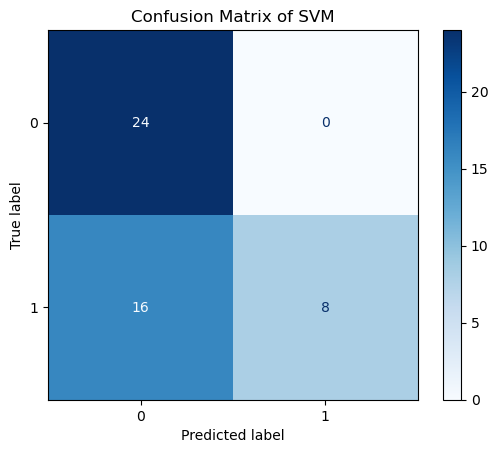

In [328]:
disp = ConfusionMatrixDisplay.from_estimator(svm, X_test_3,  y_test_3, display_labels=[0,1],cmap=plt.cm.Blues,
                                      normalize= None)
disp.ax_.set_title('Confusion Matrix of SVM')
plt.savefig(f'SVM_confusion.tiff',dpi=300)

In [241]:
labels.shape

(384,)

In [251]:
y_train

array([0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 0.])

In [335]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(selected_features_3, labels_3, test_size=0.15,stratify=labels_3)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_3, y_train_3)

y_pred_3 = knn.predict(X_test_3)

tn, fp, fn, tp = confusion_matrix(y_test_3, y_pred_3).ravel()
# compute sensitivity (true positive rate or recall)
sensitivity = tp / (tp + fn)
# compute specificity (true negative rate)
specificity = tn / (tn + fp)
# compute accuracy 
accuracy = (tp+tn)/(tp+tn+fp+fn)
print(f"sensitivity: {sensitivity}\nspecifity: {specificity}\naccuracy: {accuracy}")


sensitivity: 0.9583333333333334
specifity: 1.0
accuracy: 0.9791666666666666


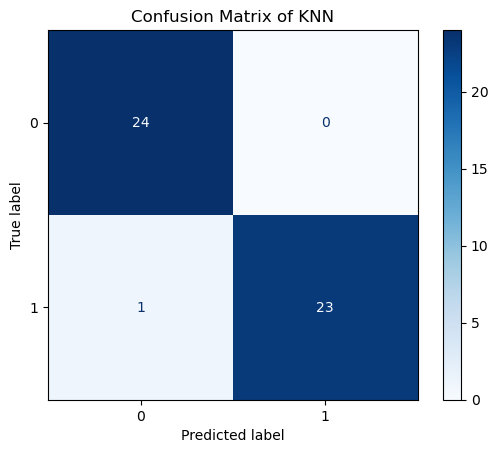

In [327]:
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test_3,  y_test_3, display_labels=[0,1],cmap=plt.cm.Blues,
                                      normalize= None)
disp.ax_.set_title('Confusion Matrix of KNN')
#plt.savefig(f'knn_confusion.tiff',dpi=300)

In [415]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(selected_features_3, labels_3, test_size=0.15,stratify=labels_3)

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_3, y_train_3)
y_pred = tree_clf.predict(X_test_3)
ass(y_test_3,y_pred)


sensitivity: 1.0
specifity: 0.9583333333333334
accuracy: 0.9791666666666666


(0.9791666666666666, 1.0, 0.9583333333333334)

In [406]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(selected_features_3, labels_3, test_size=0.15,stratify=labels_3)
gnb = GaussianNB()
gnb.fit(X_train_3, y_train_3)
y_pred = gnb.predict(X_test_3)
ass(y_test_3,y_pred)

sensitivity: 0.7916666666666666
specifity: 1.0
accuracy: 0.8958333333333334


(0.8958333333333334, 0.7916666666666666, 1.0)

In [429]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(selected_features_3, labels_3, test_size=0.2)

# Create an MLP classifier with one hidden layer of 10 neurons
mlp = MLPClassifier(hidden_layer_sizes=(3,), max_iter=1000)

# Fit the classifier to the training data
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

ass(y_test,y_pred)

sensitivity: 0.3333333333333333
specifity: 1.0
accuracy: 0.6875


(0.6875, 0.3333333333333333, 1.0)

In [474]:
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(selected_features_3, labels_3, test_size=0.2)

# Train a SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Train a MLP
mlp = MLPClassifier(random_state=1)
mlp.fit(X_train, y_train)


#get mixure of experts predictions
moe_preds = mixture_of_experts(svm, mlp, X_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=1)

In [476]:
ass(y_test,moe_preds)

sensitivity: 0.8387096774193549
specifity: 0.9696969696969697
accuracy: 0.90625


(0.90625, 0.8387096774193549, 0.9696969696969697)

In [477]:
confusion_matrix(y_test,moe_preds)

array([[32,  1],
       [ 5, 26]])

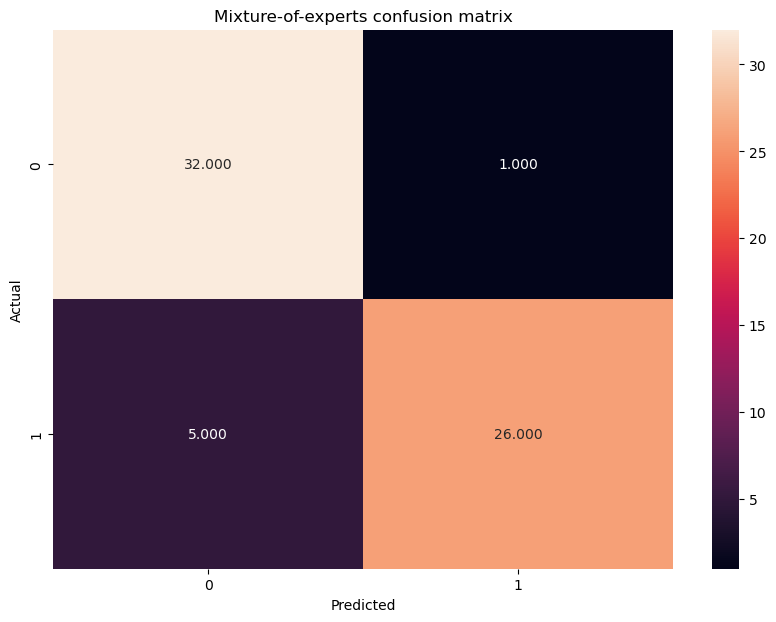

In [487]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test,moe_preds), annot=True, fmt='.3f', xticklabels=[0,1], yticklabels=[0,1])
plt.title('Mixture-of-experts confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('moe_cunfusion.tiff',dpi=300)